In [23]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import geopandas
states = geopandas.read_file('data/usa-states-census-2014.shp')
type(states)

ERROR 1: PROJ: proj_create_from_database: Open of /home/ubuntu/anaconda3/share/proj failed


geopandas.geodataframe.GeoDataFrame

In [1]:

def read_graph_from_gml(file):
    G = nx.read_gml(file)
    pos = {}
    for node, nodedata in G.nodes.items():
        if "position" in nodedata:
            pos[node] = ast.literal_eval(nodedata["position"])
        elif "Longitude" in nodedata and "Latitude" in nodedata:
            pos[node] = [nodedata['Longitude'], nodedata['Latitude']]
        else:
            raise ValueError("Cannot determine node position.")
    nx.set_node_attributes(G, pos, name='pos')
    return G

def compute_dist_lat_lon(edge,graph):
    """Compute the distance in km between two points based on their latitude and longitude.
    Assumes both are given in radians."""
    R = 6371  # Radius of the earth in km
    node1, node2 = edge
    lon1 = np.radians(graph.nodes[node1]['Longitude'])
    lon2 = np.radians(graph.nodes[node2]['Longitude'])
    lat1 = np.radians(graph.nodes[node1]['Latitude'])
    lat2 = np.radians(graph.nodes[node2]['Latitude'])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return np.round(R * c, 5)

In [171]:
import geopandas
states = geopandas.read_file('data/usa-states-census-2014.shp')
type(states)

geopandas.geodataframe.GeoDataFrame

In [164]:
f_dir = "gml_files/"
G_full = read_graph_from_gml(f_dir+"ESnet2.gml")
pos_list = nx.get_node_attributes(G_full, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=False, font_size=6, pos=pos_list)
# states.boundary.plot()
e_to_be_removed = [('EQXDC4','EQXCH2'),('WASH','NASH'),('WASH','ATLA'),('JLAB','ATLA')]
G_full.remove_edges_from(e_to_be_removed)

max_dist = 50

G_dis = G_full.copy()
for node in G_full.nodes():
    if pos_list[node][0]<-90:
        G_dis.remove_node(node)

G_subgraph_nodes = []
for G in nx.connected_components(G_dis):
    G_subgraph_nodes.append(G_subgraph_nodes)
    
orig_edges = np.copy(G.edges())
c_edge = 0
c_rep = 0
weights = dict()
for edge in orig_edges:
    dist = compute_dist_lat_lon(edge,G)
    if dist >= 2*max_dist:
        n1, n2 = edge
        G.remove_edge(n1,n2)
        c_edge += 1
        n_rep = int(dist/max_dist)-1
        G.add_nodes_from(np.arange(c_rep,c_rep+n_rep))
        G.add_edge(n1,c_rep)
        weights[(n1,c_rep)] = dist/(n_rep+1)
        i_r = 0
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        G.add_edge(c_rep+n_rep-1,n2)
        weights[(c_rep+n_rep-1,n2)] = dist/(n_rep+1)
        i_r = n_rep -1
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        for i_r in range(0,n_rep-1):
            G.add_edge(i_r+c_rep,i_r+c_rep+1)
            pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
            weights[(i_r+c_rep,i_r+c_rep+1)] = dist/(n_rep+1)

        c_rep += n_rep
    else:
        n1, n2 = edge
        weights[(n1,n2)] = dist

nx.set_edge_attributes(G, values = weights, name = 'weight')

print("No. of modified edges longer than %.0f km: " % (2*max_dist),c_edge)
print("No. of aux. nodes=",c_rep)
print("Total No. nodes=",len(G.nodes()))

end_node_list = ["PNNL","LIGO","HLAN","NETLALB","INL","SNLL",\
                "LBNL","NERSC","SLAC","LLNL","GA","NNSS","LANL-NNSS",\
                "NREL","LANL","SNLA","KCNSC-NM","NGA-SW","KCNSC",\
                "PANTEX","ORNL","DOE-SC-OSTI","FNAL","AMES","ANL",\
                "ORCC","Y12","SRS","ORAU","LNS","PSFC","NREL-DC",\
                "BNL","JLAB","PPPL","NETLPGH","NETLMGN","FRIB"]

color_map = []
for node, nodedata in G.nodes.items():
    if type(node)==np.int64:
        nodedata['type'] = 'auxiliary'
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
        else:
            nodedata['type'] = 'router'

AttributeError: 'set' object has no attribute 'edges'

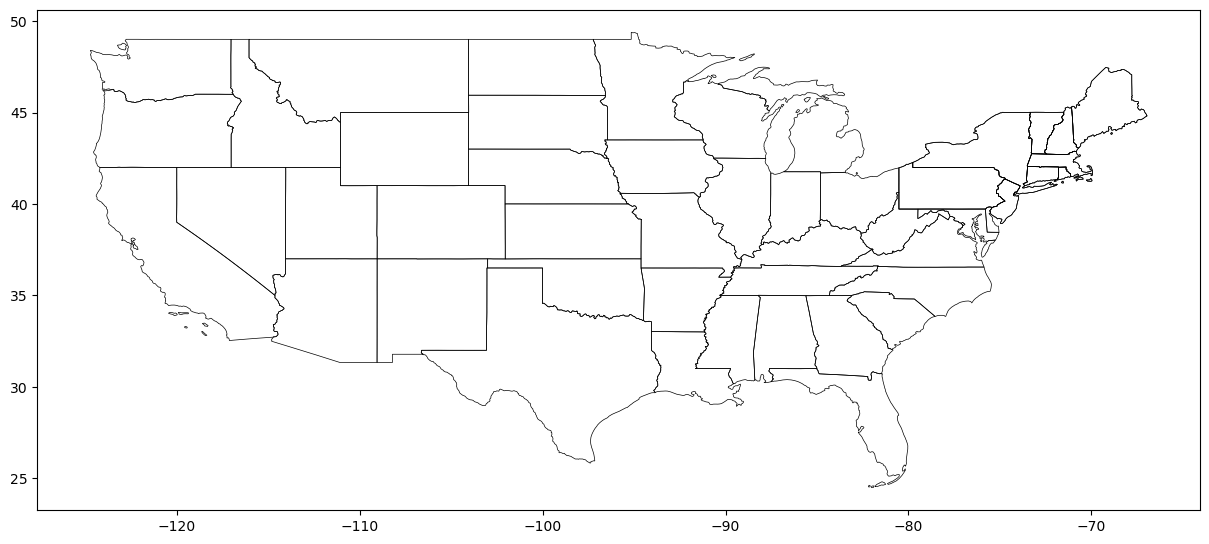

In [174]:
fig,ax = plt.subplots(figsize = (15,15))
states.boundary.plot(ax = ax,linewidth=0.5,color="black")
plt.savefig("us-map.pdf")

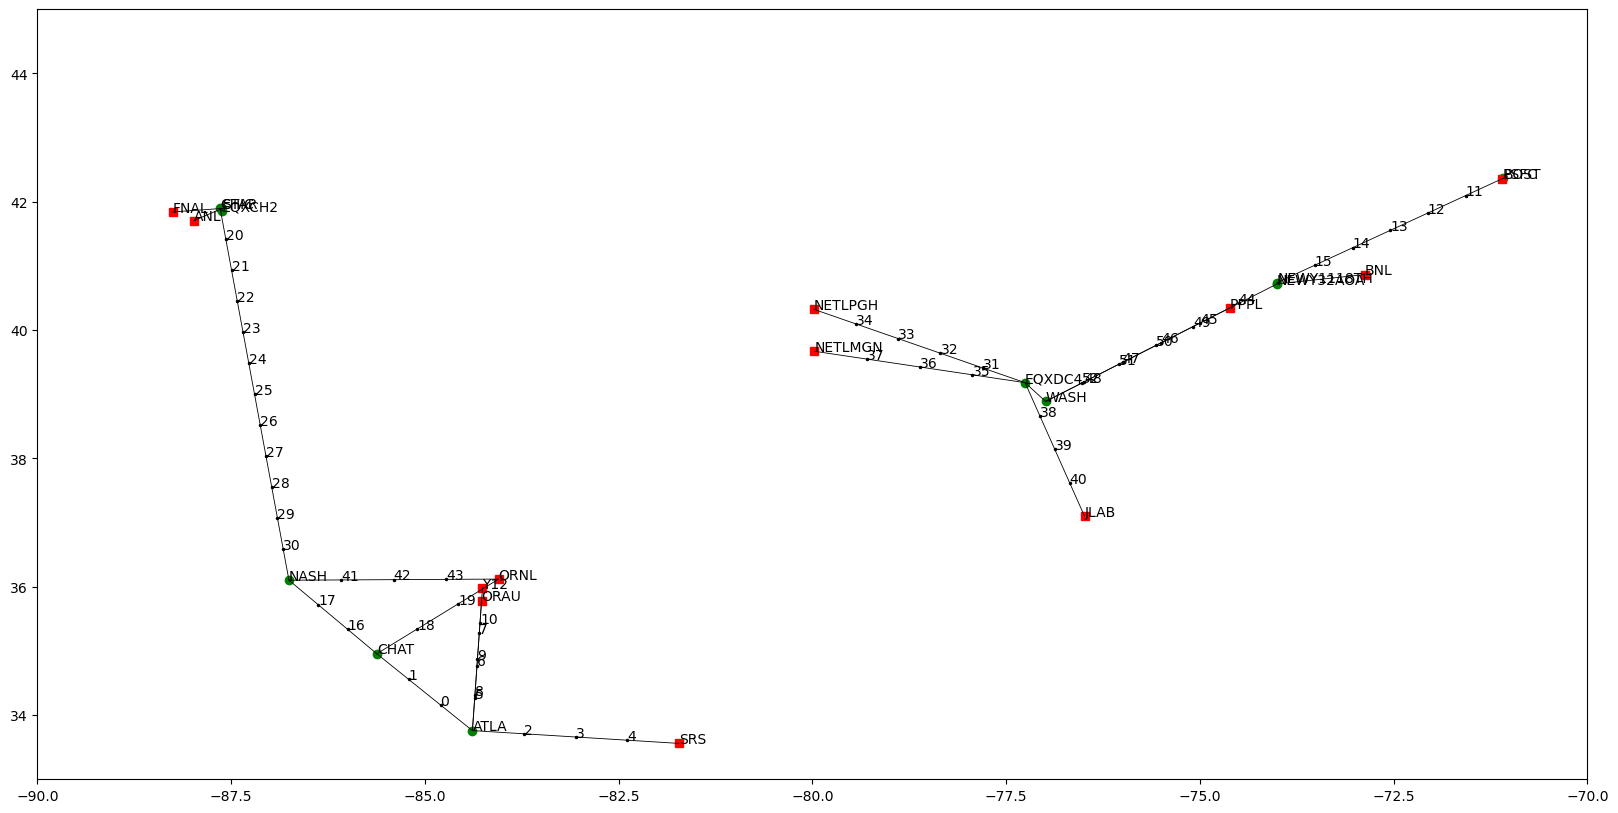

In [133]:
# fig,ax = plt.subplots(figsize = (15,15))
# states.boundary.plot(ax = ax,linewidth=0.1,color="black")

# east coast
xmin, xmax = -90,-70
ymin, ymax = 33,45

# chatanooga
# xmin, xmax = -86,-83
# ymin, ymax = 34,37

# # chicago
# xmin, xmax = -88.3,-87
# ymin, ymax = 41,42

# # new york
# xmin, xmax = -74.7,-72.5
# ymin, ymax = 40,41

fig,ax = plt.subplots(figsize = (20,10))

for node, nodedata in G.nodes.items():
    if nodedata['type'] == 'auxiliary':
        plt.plot(pos_list[node][0],pos_list[node][1],".",color='black',markersize=3)
        plt.text(pos_list[node][0],pos_list[node][1],node)
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
            plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
            if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                plt.text(pos_list[node][0],pos_list[node][1],node)
        else:
            nodedata['type'] = 'router'
            plt.plot(pos_list[node][0],pos_list[node][1],"o",color='green')
            if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                plt.text(pos_list[node][0],pos_list[node][1],node)

for link in G.edges():
    node1, node2 = link
    plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=0.6)

ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
plt.show()

In [8]:
e1 = "NETLPGH"
e2 = 156
print(nx.shortest_path_length(G, source=e1, target=e2, weight="weight"))
print(nx.shortest_path_length(G, source=e1, target=e2))
print(nx.shortest_path(G, source=e1, target=e2, weight="weight"))


106.327476
2
['NETLPGH', 157, 156]


# user pairs

In [6]:
user_pairs = [("NETLPGH","PSFC"),\
              ("NETLMGN","PPPL"),\
              ("BNL","JLAB"),\
              ("SRS","ORAU"),\
              ("Y12","FNAL"),\
              ("ORNL","ANL")]

for up in user_pairs:
    e1,e2 = up
    print(up, ", dist.[km] = ",nx.shortest_path_length(G, source=e1, target=e2, weight="weight"))

('NETLPGH', 'PSFC') , dist.[km] =  938.35236
('NETLMGN', 'PPPL') , dist.[km] =  539.6878300000001
('BNL', 'JLAB') , dist.[km] =  704.0276100000001
('SRS', 'ORAU') , dist.[km] =  472.78042999999997
('Y12', 'FNAL') , dist.[km] =  1290.4060100000002
('ORNL', 'ANL') , dist.[km] =  930.8725200000002


In [142]:
# print(G.nodes())
# nx.draw_networkx(G,pos=pos_list,with_labels=False,node_size=2,font_size=8)
# print(nx.has_path(G, source="SALT", target="DENV"))
# print(nx.shortest_path_length(G, source="NEWY1118TH", target="NEWY32AOA", weight="weight"))
n1 = "PSFC"
n2 = "NETLPGH"
print(nx.shortest_path_length(G, source=n1, target=n2, weight="weight"))
print(nx.shortest_path_length(G, source=n1, target=n2))
print(nx.shortest_path(G, source=n1, target=n2))
# print(nx.shortest_path_length(G, source="SALT", target="DENV"))
# print(nx.shortest_path_length(G, source="SALT", target="DENV", weight="weight"))


938.3523600000001
38
['PSFC', 'BOST', 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 'NEWY1118TH', 'NEWY32AOA', 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 'WASH', 'EQXDC4', 77, 78, 79, 80, 81, 82, 83, 84, 85, 'NETLPGH']


# for presentation only

In [148]:
f_dir = "gml_files/"
G_full = read_graph_from_gml(f_dir+"ESnet2.gml")
pos_list = nx.get_node_attributes(G_full, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=False, font_size=6, pos=pos_list)
# states.boundary.plot()
e_to_be_removed = [('EQXDC4','EQXCH2'),('WASH','NASH'),('WASH','ATLA'),('JLAB','ATLA')]
G_full.remove_edges_from(e_to_be_removed)

max_dist = 50

G = G_full.copy()
for node in G_full.nodes():
    if pos_list[node][0]<-90:
        G.remove_node(node)

pos_list["PPPL"][0] -= 0.3
pos_list["ORAU"][0] += 0.3

orig_edges = np.copy(G.edges())
c_edge = 0
c_rep = 0
weights = dict()
for edge in orig_edges:
    dist = compute_dist_lat_lon(edge,G)
    if dist >= 2*max_dist:
        n1, n2 = edge
        G.remove_edge(n1,n2)
        c_edge += 1
        n_rep = int(dist/max_dist)-1
        G.add_nodes_from(np.arange(c_rep,c_rep+n_rep))
        G.add_edge(n1,c_rep)
        weights[(n1,c_rep)] = dist/(n_rep+1)
        i_r = 0
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        G.add_edge(c_rep+n_rep-1,n2)
        weights[(c_rep+n_rep-1,n2)] = dist/(n_rep+1)
        i_r = n_rep -1
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        for i_r in range(0,n_rep-1):
            G.add_edge(i_r+c_rep,i_r+c_rep+1)
            pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
            weights[(i_r+c_rep,i_r+c_rep+1)] = dist/(n_rep+1)
            
        c_rep += n_rep
    else:
        n1, n2 = edge
        weights[(n1,n2)] = dist
        
nx.set_edge_attributes(G, values = weights, name = 'weight')

print("No. of modified edges longer than %.0f km: " % max_dist,c_edge)
print("No. of aux. nodes=",c_rep)
print("Total No. nodes=",len(G.nodes()))

end_node_list = ["PNNL","LIGO","HLAN","NETLALB","INL","SNLL",\
                "LBNL","NERSC","SLAC","LLNL","GA","NNSS","LANL-NNSS",\
                "NREL","LANL","SNLA","KCNSC-NM","NGA-SW","KCNSC",\
                "PANTEX","ORNL","DOE-SC-OSTI","FNAL","AMES","ANL",\
                "ORCC","Y12","SRS","ORAU","LNS","PSFC","NREL-DC",\
                "BNL","JLAB","PPPL","NETLPGH","NETLMGN","FRIB"]

color_map = []
for node, nodedata in G.nodes.items():
    if type(node)==np.int64:
        nodedata['type'] = 'auxiliary'
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
        else:
            nodedata['type'] = 'router'

No. of modified edges longer than 50 km:  14
No. of aux. nodes= 53
Total No. nodes= 76


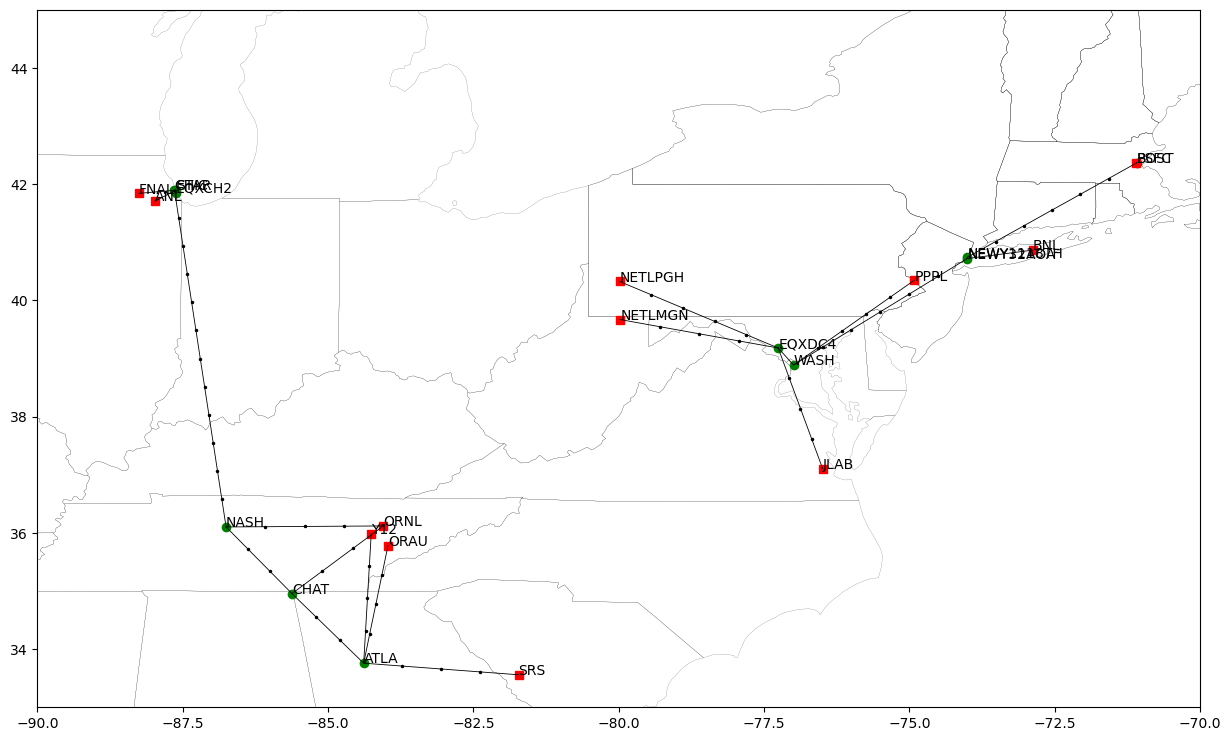

In [149]:
fig,ax = plt.subplots(figsize = (15,15))
states.boundary.plot(ax = ax,linewidth=0.1,color="black")

# east coast
xmin, xmax = -90,-70
ymin, ymax = 33,45

# # chicago
# xmin, xmax = -88.3,-87
# ymin, ymax = 41,42

# fig,ax = plt.subplots(figsize = (20,10))

for node, nodedata in G.nodes.items():
    if nodedata['type'] == 'auxiliary':
        plt.plot(pos_list[node][0],pos_list[node][1],".",color='black',markersize=3)
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
            plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
            if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                plt.text(pos_list[node][0],pos_list[node][1],node)
        else:
            nodedata['type'] = 'router'
            plt.plot(pos_list[node][0],pos_list[node][1],"o",color='green')
            if xmin<pos_list[node][0]<xmax and ymin<pos_list[node][1]<ymax:
                plt.text(pos_list[node][0],pos_list[node][1],node)

for link in G.edges():
    node1, node2 = link
    plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=0.6)

ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
plt.show()

# results

In [150]:
# user_pairs = [('NETLPGH', 'PSFC'), ('Y12', 'FNAL')]
user_pairs = [('NETLPGH', 'PSFC'),\
              ('NETLMGN', 'PPPL'),\
              ('BNL', 'JLAB'), ('SRS', 'ORAU'),\
              ('Y12', 'FNAL'), ('ORNL', 'ANL')]
# paths = [ [('NETLPGH',80), (80,'EQXDC4'), ('EQXDC4',112), (112,110), (110,'NEWY1118TH'), ('NEWY1118TH',46), (46,45), (45,44), (44,42), (42,'PSFC')],\
#           [('Y12','CHAT'), ('CHAT','NASH'), ('NASH',59), (59,56), (56,55), (55,53), (53,'STAR'), ('STAR','FNAL')]\
#         ]
paths_finite_F = [
    [('NETLPGH',80), (80,'EQXDC4'), ('EQXDC4',112), (112,110), (110,'NEWY1118TH'), ('NEWY1118TH',46), (46,45), (45,44), (44,42), (42,'PSFC')], \
    [('NETLMGN',85), (85,84), (84,83), (83,'EQXDC4'), ('EQXDC4','WASH'), ('WASH',117), (117,116), (116,115), (115,114), (114,'PPPL')], \
    [('BNL','NEWY32AOA'), ('NEWY32AOA',109), (109,110), (110,111), (111,112), (112,113), (113,'WASH'), ('WASH',86), (86,87), (87,88), (88,'JLAB')], \
    [('SRS',4), (4,3), (3,2), (2,'ATLA'), ('ATLA',21),(21,22), (22,23), (23,'ORAU')],\
    [('Y12','CHAT'), ('CHAT','NASH'), ('NASH',59), (59,56), (56,55), (55,53), (53,'STAR'), ('STAR','FNAL')], \
    [('ORNL',61), (61,58), (58,55), (55,52), (52,'ANL')]]

w_finite_F = [5,5,5,10,5,5]

paths_finite_q = [[('NETLPGH',80), (80,'EQXDC4'), ('EQXDC4',112), (112,110), (110,'NEWY1118TH'), ('NEWY1118TH',46),(46,45), (45,44), (44,42), (42,'PSFC')],\
                  [('NETLMGN',85), (85,84), (84,83), (83,'EQXDC4'),('EQXDC4','WASH'), ('WASH',117), (117,116), (116,115), (115,114), (114,'PPPL')],\
                  [('BNL','NEWY32AOA'), ('NEWY32AOA',109),(109,110), (110,111), (111,112), (112,113), (113,'WASH'),('WASH',86), (86,87), (87,88), (88,'JLAB')],\
                  [('SRS',4), (4,3), (3,2), (2,'ATLA'), ('ATLA',21),(21,22), (22,23), (23,'ORAU')],\
                  [('Y12','CHAT'), ('CHAT',61), (61,59), (59,56), (56,55), (55,53), (53,'STAR'), ('STAR','FNAL')], \
                  [('ORNL',61), (61,58), (58,55), (55,52), (52,'ANL')]]
w_finite_q = [5,5,5,10,5,5]

paths_finite_q =[[('NETLPGH',80), (80,'EQXDC4'), ('EQXDC4',112), (112,110), (110,'NEWY1118TH'), ('NEWY1118TH',46), (46,45), (45,44), (44,42), (42,'PSFC')],\
                 [('NETLMGN',85), (85,84), (84,83), (83,'EQXDC4'), ('EQXDC4','WASH'), ('WASH',117), (117,116), (116,115), (115,114), (114,'PPPL')],\
                 [('BNL','NEWY32AOA'), ('NEWY32AOA',109), (109,110), (110,111), (111,112), (112,113), (113,'WASH'),('WASH',86), (86,87), (87,88), (88,'JLAB')],\
                 [('SRS',4), (4,3), (3,2), (2,'ATLA'), ('ATLA',21), (21,22), (22,23), (23,'ORAU')],\
                 [('Y12','CHAT'), ('CHAT',61), (61,59), (59,56),(56,55), (55,53), (53,'STAR'), ('STAR','FNAL')],\
                 [('ORNL',61), (61,58), (58,55), (55,52), (52,'ANL')]\
                ]

paths_finite_q = [[('NETLPGH',82), (82,80), (80,77), (77,120),(120,113), (113,41), (41,'PSFC')],\
                 [('NETLMGN',92), (92,88), (88,'WASH'), ('WASH',131), (131,128), (128,125), (125,'PPPL')],\
                 [('BNL',111), (111,116), (116,121), (121,98), (98,'JLAB')],\
                 [('SRS',11), (11,10), (10,8), (8,6), (6,'ATLA'), ('ATLA',14), (14,16), (16,18), (18,19), (19,'ORAU')],\
                 [('Y12',28), (28,27), (27,26), (26,21), (21,67), (67,63), (63,102), (102,'FNAL')],\
                 [('ORNL',107), (107,106), (106,103), (103,76), (76,71), (71,66), (66,64), (64,61), (61,56),(56,'ANL')]]


#### linked bases
# for q=0.5 F=1.0 max_dist = 50km
user_pairs = [('SRS', 'ORAU'),('Y12', 'FNAL'),('ORNL', 'ANL')]
paths_finite_q = [[('ATLA', 17), ('SRS', 16), (14, 'ATLA'), (15, 14), (16, 15), (17, 18), (18, 19), (19, 'ORAU')],
                [('ATLA', 'CHAT'), ('CHAT', 'NASH'), ('CHIC', 'FNAL'), ('NASH', 37), ('Y12', 21), (21, 'ATLA'), (27, 'CHIC'), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 33), (35, 34), (36, 35), (37, 36)] ,
                [('CHIC', 'ANL'), ('NASH', 37), ('ORNL', 39), (27, 'CHIC'), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 33), (35, 34), (36, 35), (37, 36), (39, 'NASH')]]



('SRS', 'ORAU')


NetworkXNoPath: No path between 14 and ATLA.

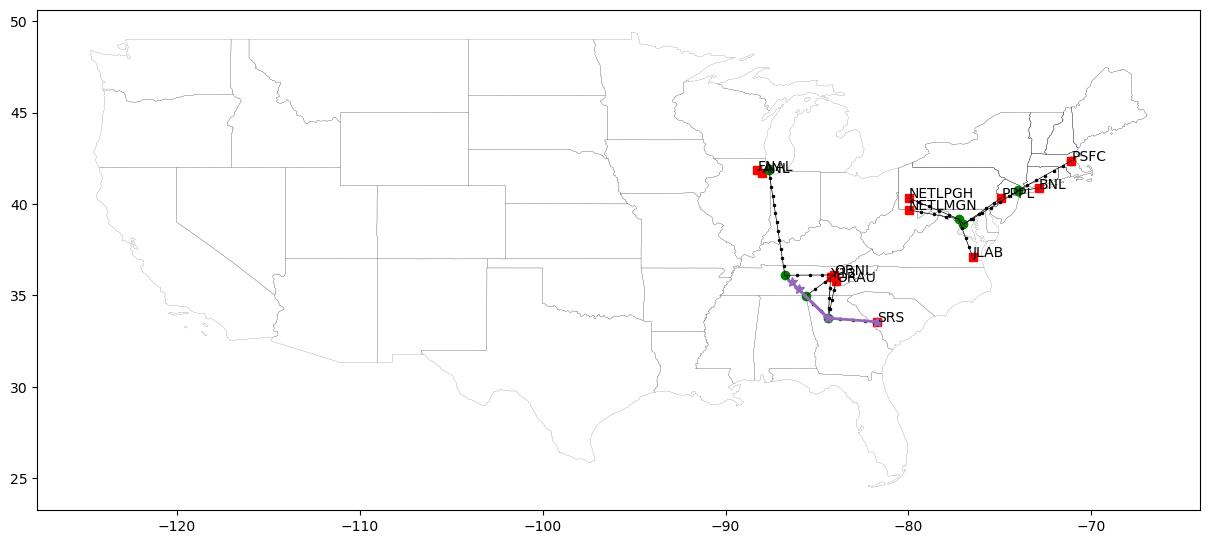

In [151]:
fig,ax = plt.subplots(figsize = (15,15))
states.boundary.plot(ax = ax,linewidth=0.1,color="black")

# fig,ax = plt.subplots(figsize = (20,10))

for node, nodedata in G.nodes.items():
    if nodedata['type'] == 'auxiliary':
        plt.plot(pos_list[node][0],pos_list[node][1],".",color='black',markersize=3)
    else:
#     if nodedata['type'] != 'auxiliary':
        if node in end_node_list:
            nodedata['type'] = 'site'
            plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
            plt.text(pos_list[node][0],pos_list[node][1],node)
        else:
            nodedata['type'] = 'router'
            plt.plot(pos_list[node][0],pos_list[node][1],"o",color='green')

for link in G.edges():
    node1, node2 = link
    plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=0.5)

paths = paths_finite_q
shift_color = 4
for i_u, user_pair in enumerate(user_pairs):
# for i_u in [0,1]:
# i_u = 2
    user_pair = user_pairs[i_u]
    print(user_pair)
    e2e_path = paths[i_u]
    dist_list = []
    for i in range(len(e2e_path)):
        e = e2e_path[i]
#         print(e)
    #         print(e)
    #         plt.plot([ pos_list[e1][0],pos_list[e2][0] ], [ pos_list[e1][1],pos_list[e2][1] ], color = "C%d" % i_u, linewidth=1)
        if G.has_edge(e[0],e[1]):
    #             if plot_on:
            plt.plot([ pos_list[e[0]][0],pos_list[e[1]][0] ], [ pos_list[e[0]][1],pos_list[e[1]][1] ], color = "C%d" % (i_u+shift_color), linewidth=2)
            dist_list.append(nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight"))
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            dist_list.append(nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight"))
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
    #                 if plot_on:
                plt.plot([ pos_list[e1][0],pos_list[e2][0] ], [ pos_list[e1][1],pos_list[e2][1] ], color = "C%d" % (i_u+shift_color), linewidth=2)

        plt.plot(pos_list[e[0]][0], pos_list[e[0]][1], "*",markersize=7, color = "C%d" % (i_u+shift_color))
        plt.plot(pos_list[e[1]][0], pos_list[e[1]][1], "*",markersize=7, color = "C%d" % (i_u+shift_color))

# plt.xlim([-125,-115]) # i_u = 1
# plt.xlim([-125,-110]) # i_u = 2
# plt.ylim([30,45])
# plt.ylim([35,43])
# plt.xlim([-80,-70])

# east coast
xmin, xmax = -90,-70
ymin, ymax = 33,45

ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

plt.show()
print(dist_list)

In [147]:
from math import comb
comb(10,3)

120